In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
arith_rgb_to_gray = pd.read_csv("../bench/arith_rgb_to_gray.csv")
linalg_assoc = pd.read_csv("../bench/linalg_assoc.csv")
math_inv_sqrt = pd.read_csv("../bench/math_inv_sqrt.csv")
math_horners_method = pd.read_csv("../bench/math_horners_method.csv")

In [3]:
# combine "-O0" col from all dataframes into one dataframe
df = pd.concat([arith_rgb_to_gray, linalg_assoc, math_inv_sqrt, math_horners_method], ignore_index=True)
df

,name,opt,-O3
0,arith_rgb_to_gray,canon,24232.5
1,arith_rgb_to_gray,canon+eqsat,20292.5
2,arith_rgb_to_gray,eqsat+canon,20464.0
3,arith_rgb_to_gray,noopt,24358.0
4,arith_rgb_to_gray,eqsat,21414.0
5,linalg_assoc,eqsat,16.0
6,linalg_assoc,noopt,119.5
7,linalg_assoc,canon,122.5
8,linalg_assoc,eqsat+canon,15.5
9,linalg_assoc,canon+eqsat,13.5


In [4]:
# Renanem names to nice names
df['name'] = df['name'].replace({
    "arith_rgb_to_gray": "RGB Image to Gray",
    "linalg_assoc": "MatMul Associativity",
    "math_inv_sqrt": "Vector Normalization",
    "math_horners_method": "Polynomial"
})

df['opt'] = df['opt'].replace({
    "noopt": "No Optimization",
    "canon": "Canonicalization",
    "eqsat": "DragonEgg",
    "eqsat+canon": "DragonEgg + Canonicalization",
    "canon+eqsat": "Canonicalization + DragonEgg"
})

In [5]:
df_opt = df[['name', 'opt', "-O3"]]
df_pivot = df_opt.pivot(index='name', columns='opt', values="-O3")
df_pivot

opt,Canonicalization,Canonicalization + DragonEgg,DragonEgg,DragonEgg + Canonicalization,No Optimization
name,,,,,
Horner's Method,2109.5,2090.0,1793.0,2090.5,2002.5
MatMul Associativity,122.5,13.5,16.0,15.5,119.5
RGB Image to Gray,24232.5,20292.5,21414.0,20464.0,24358.0
Vector Normalization,3014.5,3612.5,3098.0,3311.5,2970.0


In [6]:
# speedup = baseline / optimized
(1 / df_pivot).mul(df_pivot['No Optimization'], axis=0)

opt,Canonicalization,Canonicalization + DragonEgg,DragonEgg,DragonEgg + Canonicalization,No Optimization
name,,,,,
Horner's Method,0.949277,0.958134,1.116843,0.957905,1.0
MatMul Associativity,0.975510,8.851852,7.468750,7.709677,1.0
RGB Image to Gray,1.005179,1.200345,1.137480,1.190285,1.0
Vector Normalization,0.985238,0.822145,0.958683,0.896875,1.0


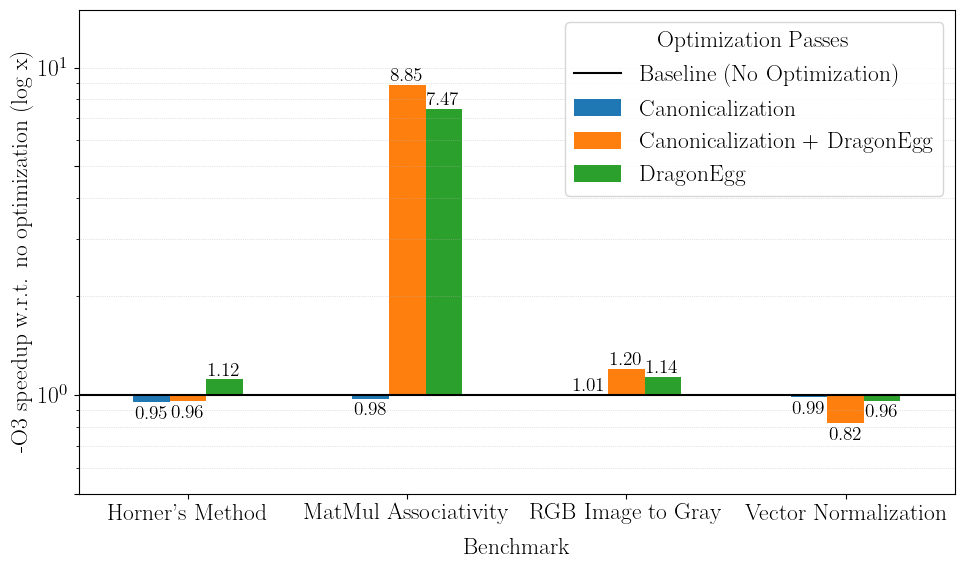

In [24]:
# create 1 speedup plot for each opt level: [-O0, -O1, -O2, -O3]
# the baseline is opt=noopt
for opt_level in ["-O3"]:
    # Filter the dataframe for the current optimization level
    df_opt = df[['name', 'opt', opt_level]]
    
    # Pivot the dataframe to have optimizations as columns
    df_pivot = df_opt.pivot(index='name', columns='opt', values=opt_level)
    df_pivot = df_pivot.drop(columns=['DragonEgg + Canonicalization'], errors='ignore')
    
    # Calculate speedup relative to 'noopt'
    df_speedup = (1.0 / df_pivot).mul(df_pivot['No Optimization'], axis=0) 
    df_speedup = df_speedup.drop(columns=['No Optimization'], errors='ignore')

    # Create the speedup plot
    ax = df_speedup.plot(kind='bar', figsize=(10, 6))
    plt.grid(True, which='both', axis='y', zorder=0, linestyle=':', linewidth=0.5, alpha=0.7)
    plt.rcParams.update({'font.size': 17})

    # enable latex

    # Customize the plot
    plt.xlabel('Benchmark', labelpad=10, fontdict={'family': 'Libertine'})
    plt.ylabel(f'{opt_level} speedup w.r.t. no optimization (log x)', fontdict={'family': 'Libertine'})
    plt.axhline(y=1, color='black', linestyle='-', label='Baseline (No Optimization)')
    plt.legend(title='Optimization Passes', loc='upper right', fontsize=17)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0, ha='center')
    plt.yscale('log')
    plt.ylim(0.5, 15)
    plt.yticks([0.5, 1, 5, 10])

    # Add speedup numbers on top of each bar
    for container in ax.containers:
        # ax.bar_label(container, fmt='%.2f')
        for bar in container:
            bar_height = bar.get_height()
            bar.set_height(bar_height - 1)
            bar.set_y(1)

            # label under the bar if bar_height < 1
            if bar_height < 1:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height - 0.02, f'{bar_height:.2f}', ha='center', va='top', fontsize=14)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{bar_height:.2f}', ha='center', va='bottom', fontsize=14)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # save the plot to a file
    plt.savefig(f"../bench/speedup{opt_level}.png")
    plt.savefig(f"/Users/aziz/Documents/2-School/Research Summer 2024/paper/assets/speedup{opt_level}.png")

    plt.show()